In [ ]:
!pip install kaggle
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tensorflow

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import ast
import os

print("\n","Tensorflow version " + tf.__version__)


 Tensorflow version 2.15.0


In [ ]:
os.environ['KAGGLE_USERNAME'] = "antoineguines"
os.environ['KAGGLE_KEY'] = "763e4e8c48ce54809476f469031bd265"

!mkdir model
!mkdir dataframe
!kaggle datasets download -d gsimonx37/letterboxd
!unzip letterboxd.zip
!rm actors.csv countries.csv crew.csv languages.csv movies.csv releases.csv studios.csv themes.csv

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: posters/1883123.jpg     
  inflating: posters/1883132.jpg     
  inflating: posters/1883133.jpg     
  inflating: posters/1883144.jpg     
  inflating: posters/1883145.jpg     
  inflating: posters/1883146.jpg     
  inflating: posters/1883148.jpg     
  inflating: posters/1883155.jpg     
  inflating: posters/1883156.jpg     
  inflating: posters/1883159.jpg     
  inflating: posters/1883161.jpg     
  inflating: posters/1883162.jpg     
  inflating: posters/1883167.jpg     
  inflating: posters/1883169.jpg     
  inflating: posters/1883175.jpg     
  inflating: posters/1883180.jpg     
  inflating: posters/1883184.jpg     
  inflating: posters/1883185.jpg     
  inflating: posters/1883188.jpg     
  inflating: posters/1883190.jpg     
  inflating: posters/1883191.jpg     
  inflating: posters/1883196.jpg     
  inflating: posters/1883202.jpg     
  inflating: posters/1883207.jpg     
  inflatin

# I- Pre-processing the data

We start by loading in a panda dataframe our genres.csv file.

In [ ]:
df_genre = pd.read_csv("genres.csv")

print(df_genre.shape)
print("Genres :\n", np.sort(df_genre['genre'].unique()), "\n")
print("Numbers of genre :", df_genre['genre'].nunique(), "\n")
print("Numbers of film :", df_genre['id'].nunique(), "\n")
print("Occurences of each genre in the dataset : \n\n", df_genre['genre'].value_counts(), "\n")
print("first lines of the dataset : \n", df_genre.head(10))

(990770, 2)
Genres :
 ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Mystery' 'Romance'
 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western'] 

Numbers of genre : 19 

Numbers of film : 638632 

Occurences of each genre in the dataset : 

 genre
Drama              219936
Documentary        153666
Comedy             134220
Animation           54701
Romance             49605
Horror              48688
Thriller            44201
Music               41871
Action              40291
Crime               33975
Family              26612
TV Movie            24596
Adventure           22281
Fantasy             21013
Mystery             20046
Science Fiction     19901
History             16217
War                 10312
Western              8638
Name: count, dtype: int64 

first lines of the dataset : 
         id            genre
0  1000001           Comedy
1  1000001          Fantasy
2  1000001        Adventure
3  1000002 

Then we start cleaning and creating the different dataset we will need for the following part of this notebook.
So here are grouped together all the functions for preprocessing our dataset, and creating the different datasets that we'll use later.

In [ ]:
# function that deletes films that are not associated with a poster
def delete_films_without_poster(df, path_posters):

    existing_poster = os.listdir(path_posters)
    mask_existing_poster = df['filename'].isin(existing_poster)
    df_fwp = df[mask_existing_poster].copy()

    return df_fwp


# function that deletes films associated with no genre
def delete_films_without_genre(df):

    # delete Na value
    df_fwg = df.dropna(subset=['genre'])
    # delete blank value
    df_fwg = df_fwg[df_fwg['genre'].str.strip() != '']

    return df_fwg


# function that deletes films associated with more than N genres
def delete_films_w_more_N_genre(df):

    N = 3
    genre_counts = df['id'].value_counts()
    valid_films = genre_counts[genre_counts <= N].index
    df_valid = df[df['id'].isin(valid_films)].reset_index()
    df_valid = df_valid.drop(columns=['index'])

    return df_valid

# function that delete all the film associated to a genre, and therefore the genre itself
def delete_genre(df, genre):

    df_del = df[df['genre'] != genre].reset_index(drop=True)
    df_del = df_del.sample(frac=1).reset_index(drop=True)

    return df_del

# function that balanced a datset such that no genre are represented over the limits n
def balance_genres(df, n):

    df_eq = df.groupby('genre').apply(lambda x: x.sample(min(len(x), n))).reset_index(drop=True)

    return df_eq

# function that select the 6 most represented genre
def process_select_genre(df):

    top_genre = df['genre'].value_counts().nlargest(6).index.tolist()
    df_select = df.copy()

    for genre in df['genre'].unique():
        if genre not in top_genre:
            df_select = delete_genre(df_select, genre)

    return df_select


# function that returns films associated to one and only one genre
def films_with_one_genre(df):

    genre_counts = df['id'].value_counts()
    films_with_only_one_genre = genre_counts[genre_counts == 1].index
    df_one = df[df['id'].isin(films_with_only_one_genre)].reset_index()
    df_one = df_one.drop(columns=['index'])
    df_one = df_one.sample(frac=1).reset_index(drop=True) ##

    return df_one


# function that creates a dictionnary where each genre is associated to an integer. We'll use it later for one hot encoding.
def create_dict_genre_to_index(df_dict, name):

    list_of_genre = np.sort(df_dict['genre'].unique())
    genre_to_index = {genre: index for index, genre in enumerate(list_of_genre)}
    with open(f'{name}.json', 'w') as json_file:
        json.dump(genre_to_index, json_file)

    return 0


# function that groups the genre associated to each film in a list
def group_the_genre(df):

    df_grp = df.groupby('filename')['genre'].apply(list).reset_index()
    df_grp = df_grp.sample(frac=1).reset_index(drop=True)

    return df_grp


# function that splits the dataframe s.t : train set = 60% - val set = 20% - test set = 20%
def split_dataframe(df):

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    return df_train, df_val, df_test

def calculate_sample_weights(df):

     genre_counts = df['genre'].value_counts()

     inverse_counts = 1.0 / genre_counts

     normalized_weights = inverse_counts / inverse_counts.sum()

     sorted_genres = sorted(normalized_weights.index)

     sorted_weights = np.array([normalized_weights[genre] for genre in sorted_genres])

     return sorted_weights


def process_df(df, poster_path):

    #we create a dictionnary, each genre associate to an index from 0 to 18, for latter use.
    create_dict_genre_to_index(df, 'genre_to_index')

    # we add a column filename
    df['filename'] = df['id'].astype(str) + '.jpg'

    # we delete films without poster
    df = delete_films_without_poster(df, poster_path)

    # we delete films without genre (if there are)
    df = delete_films_without_genre(df)

    # we delete films with more than N (here N=3) genre
    df = delete_films_w_more_N_genre(df)
    # we shuffle the dataset, because the films are not well spread.
    #df = df.sample(frac=1).reset_index(drop=True)

    df_one = films_with_one_genre(df)

    df_genre_selected = process_select_genre(df_one)
    create_dict_genre_to_index(df_genre_selected, 'genre_to_index_selected')
    df_genre_selected = balance_genres(df_genre_selected, 25000)

    df_one = group_the_genre(df_one)
    df_genre_selected = group_the_genre(df_genre_selected)
    df_full_grp = group_the_genre(df)

    df_one_train, df_one_val, df_one_test = split_dataframe(df_one)
    df_full_train, df_full_val, df_full_test = split_dataframe(df_full_grp)
    df_selected_train, df_selected_val, df_selected_test = split_dataframe(df_genre_selected)


    # we save these dataset, in order to do not need to repeat this part again
    df.to_csv('dataframe/clean_dataframe.csv', index=False)

    df_one.to_csv('dataframe/df_one_genre.csv', index=False)
    df_one_train.to_csv('dataframe/training_set_one_genre.csv', index=False)
    df_one_val.to_csv('dataframe/validation_set_one_genre.csv', index=False)
    df_one_test.to_csv('dataframe/test_set_one_genre.csv', index=False)

    df_full_grp.to_csv('dataframe/df_full_grouped.csv', index=False)
    df_full_train.to_csv('dataframe/training_set_full.csv', index=False)
    df_full_val.to_csv('dataframe/validation_set_full.csv', index=False)
    df_full_test.to_csv('dataframe/test_set_full.csv', index=False)

    df_genre_selected.to_csv('dataframe/df_genres_selected.csv', index=False)
    df_selected_train.to_csv('dataframe/training_set_genres_selected.csv', index=False)
    df_selected_val.to_csv('dataframe/validation_set_genres_selected.csv', index=False)
    df_selected_test.to_csv('dataframe/test_set_genres_selected.csv', index=False)

    return df

In [ ]:
POSTER_PATH = 'posters/'
df = process_df(df_genre, POSTER_PATH)

Now that the first stage of pre-processing has been completed, we can get down to business and try to build a model that allows us to guess the genre of a film from its poster.
This notebook is organised according to the order of reasoning that has been carried out, and so we naively start by trying to guess the genres of the films on the entire dataset. In other words, we keep the 19 genres, and each film can be associated with several genres. This kind of problem refers to a multi-label classification problem.

# II- Multi-labels Classification (MLC)

So in this first part, We're going to consider the entire clean dataset, so we'll keep all 19 genres, as well as the films associated with several genres at once. Let's see some statistics about this dataset.

In [ ]:
df_full = pd.read_csv("dataframe/clean_dataframe.csv")
df_full_grp = pd.read_csv("dataframe/df_full_grouped.csv")
print("Numbers of film in df_one_genre :", df_full_grp.shape[0],'\n')
print("Occurences of each genre in df_one_genre : \n\n", df_full['genre'].value_counts(), "\n")
print("How the first line of our dataset looks : \n", df_full_grp.head(10),'\n')

Numbers of film in df_one_genre : 539810 

Occurences of each genre in df_one_genre : 

 genre
Drama              188213
Documentary        124829
Comedy             113841
Romance             42917
Animation           42070
Horror              41941
Music               36826
Thriller            35692
Action              31465
Crime               27224
Family              20562
TV Movie            18440
Adventure           15717
Mystery             15038
Science Fiction     14884
Fantasy             14785
History             13166
War                  8365
Western              7188
Name: count, dtype: int64 

How the first line of our dataset looks : 
       filename                         genre
0  1817776.jpg  ['Adventure', 'Documentary']
1  1056047.jpg               ['Documentary']
2  1613442.jpg                     ['Music']
3  1623296.jpg                   ['Western']
4  1074576.jpg          ['Drama', 'Romance']
5  1521295.jpg                     ['Drama']
6  1347318.jpg          

### a) Loading and building training and validation set

In [51]:
SAMPLE_SIZE_1 = 5000
BATCH_SIZE_1 = 64
poster_dir = 'posters/'
AUTO = tf.data.experimental.AUTOTUNE
genre_Number = 19
global genre_Number

In [52]:
df_train = pd.read_csv("dataframe/training_set_full.csv")
df_train = df_train.sample(int(SAMPLE_SIZE_1*0.8), random_state=42)
df_val = pd.read_csv("dataframe/validation_set_full.csv")
df_val = df_val.sample(int(SAMPLE_SIZE_1*0.2), random_state=42)

In [53]:
print("Number of film in training set :", df_train.shape[0], "\n")
print("Number of film in validation set :", df_val.shape[0], "\n")
print("sum : ", df_train.shape[0]+df_val.shape[0], "\n")

Number of film in training set : 4000 

Number of film in validation set : 1000 

sum :  5000 



In [54]:
def one_hot_encode(genre):

    global genre_Number
    if (genre_Number == 19):
        with open('genre_to_index.json', 'r') as json_file:
            GTI = json.load(json_file)
    else:
         with open('genre_to_index_selected.json', 'r') as json_file:
            GTI = json.load(json_file)

    genre_str = genre.numpy().decode('utf-8')
    genre_list = ast.literal_eval(genre_str)
    l = []

    for i in range(len(genre_list)):
        g = genre_list[i]
        int_lab = GTI.get(g, None)
        if int_lab is None:
            raise ValueError(f"Genre {g} non trouvé dans GTI.")
        l.append(int_lab)

    label = tf.one_hot(l, genre_Number)
    label = tf.reduce_sum(label, axis=0)

    return label


def transform_into_tf(df):

    filenames = df['filename'].tolist()
    genres = df['genre'].tolist()
    ds_dict = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(genres), filenames))

    return ds_dict


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    image.set_shape([256, 256, 3])
    return image


def parse_function(e0, e1):
    global genre_Number
    image_path = tf.strings.join([poster_dir, e1], separator=os.sep)
    image = read_image(image_path)
    label = tf.py_function(one_hot_encode, [e0], tf.float32)
    label.set_shape([genre_Number])
    return image, label

def get_dataset(image_file, df, batch_size):

    ds = transform_into_tf(df)
    dataset = ds.map(parse_function, num_parallel_calls=AUTO)
    #dataset = dataset.repeat()

    # Depend on the size of the dataset we are working with. If it can be entirely cached in RAM or not.
    # So if we only work on small sample we can use it.
    #dataset = dataset.cache()

    #dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

    # fetch next batches while training on the current one
    dataset = dataset.prefetch(AUTO)

    return dataset

In [55]:
ds_train = get_dataset(poster_dir, df_train, BATCH_SIZE_1)
ds_val = get_dataset(poster_dir, df_val, BATCH_SIZE_1)

### b) Creating and training the MLC model

We create the MLCModel class to define our model

In [ ]:
class MLCModel:

    def __init__(self, input_shape=(256, 256, 3), num_classes=19, dropout_rate=0.3, seed=40):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.seed = seed
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()

        model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Flatten())
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(self.num_classes, activation='sigmoid'))

        return model

    def get_model(self):
        return self.model

In [ ]:
mlc = MLCModel()
model_1 = mlc.get_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model compilation and architecture display #
model_1.compile(optimizer='adam', loss='binary_crossentropy')
model_1.summary()

# train the model #
hist_1 = model_1.fit(ds_train, epochs=2, validation_data=ds_val, callbacks = [early_stopping])
#model_1.save('model/mlc_model_adam_ss=10000_epoch=10.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 32)      1

In [56]:
def plot_train_and_val_loss(hist):
    plt.plot(hist.history['loss'], color = 'blue', label = 'train_loss')
    plt.plot(hist.history['val_loss'], color = 'orange', label = 'validation_loss')
    plt.title('Loss on train and validation set through epoch')
    plt.legend()
    plt.show()
    return

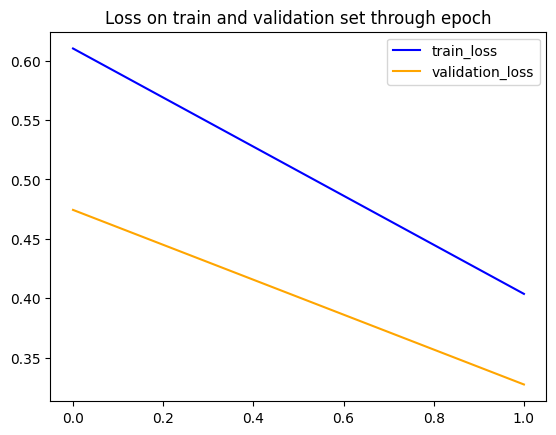

In [57]:
plot_train_and_val_loss(hist_1)

### c) Evaluation of the MLC model on test set

In [ ]:
#from tensorflow.keras.models import load_model
#model_1 = load_model('model/mlc_model_adam_ss=10000_epoch=10.keras')

In [58]:
df_test = pd.read_csv("dataframe/test_set_full.csv")
df_test = df_test.sample(int(SAMPLE_SIZE_1*0.8), random_state=42)

In [59]:
ds_test = get_dataset(poster_dir, df_test, BATCH_SIZE_1)

In [60]:
model_1.evaluate(ds_test)

62/62 [==============================] - 224s 4s/step - loss: 0.3252


0.3251788020133972

In [61]:
proba = model_1.predict(ds_test)
print(proba)

62/62 [==============================] - 179s 3s/step
[[0.09843417 0.16784962 0.28611025 ... 0.16302085 0.20811227 0.16827899]
 [0.11984415 0.19239494 0.3195991  ... 0.18801922 0.24019359 0.18289119]
 [0.1960301  0.24947742 0.3409066  ... 0.21222988 0.3208737  0.19182244]
 ...
 [0.11268474 0.17275117 0.25872707 ... 0.17507625 0.21153973 0.19751254]
 [0.3033363  0.30369547 0.3092251  ... 0.17599319 0.18972665 0.19179769]
 [0.16918221 0.20686722 0.2625062  ... 0.17258617 0.2191247  0.20259218]]


In [65]:
y_true = np.concatenate([y for x, y in ds_test], axis=0)

In [66]:
correct_predictions = 0
for i in range(len(proba)):
    best_indices = np.argsort(proba[i])[-3:]

    if any(y_true[i][index] == 1 for index in best_indices):
        correct_predictions += 1

average_at_least_one_good_pred = correct_predictions / len(proba)

In [67]:
print(average_at_least_one_good_pred)

0.6590221774193549


# III- Multi-Class Classification (MCC)

In this second part we're trying to simplify the problem a little in the hope of achieving better results. For this purpose, we now consider the df_one_genre dataset, made up solely of films associated with a single genre.
Here are some statistics about this dataset.

In [ ]:
df_one_genre = pd.read_csv("dataframe/df_one_genre.csv")
print("Numbers of film in df_one_genre :", df_one_genre.shape[0],'\n')
print("Occurences of each genre in df_one_genre : \n\n", df_one_genre['genre'].value_counts(), "\n")

Numbers of film in df_one_genre : 327438 

Occurences of each genre in df_one_genre : 

 genre
['Documentary']        99964
['Drama']              86533
['Comedy']             46779
['Animation']          22507
['Music']              18072
['Horror']             17628
['Thriller']            5649
['Action']              5421
['Romance']             5026
['Western']             4040
['Crime']               3133
['Family']              2891
['Science Fiction']     2663
['Fantasy']             1740
['Adventure']           1621
['Mystery']             1606
['History']              766
['War']                  762
['TV Movie']             637
Name: count, dtype: int64 



### a) Loading and building training and validation dataset

In [ ]:
SAMPLE_SIZE_2 = 5000
BATCH_SIZE_2 = 64
poster_dir = 'posters/'
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
df_one_train = pd.read_csv("dataframe/training_set_one_genre.csv")
df_one_train = df_one_train.sample(int(SAMPLE_SIZE_2*0.8), random_state=42)
df_one_val = pd.read_csv("dataframe/validation_set_one_genre.csv")
df_one_val = df_one_val.sample(int(SAMPLE_SIZE_2*0.2), random_state=42)

In [ ]:
print("Number of film in training set :", df_one_train.shape[0], "\n")
print("Number of film in validation set :", df_one_val.shape[0], "\n")
print("sum : ", df_one_train.shape[0]+df_one_val.shape[0], "\n")
print(df_one_train.head())

Number of film in training set : 4000 

Number of film in validation set : 1000 

sum :  5000 

           filename       genre
162323  1868192.jpg   ['Drama']
76775   1580757.jpg   ['Music']
11699   1363676.jpg   ['Drama']
188905  1684876.jpg   ['Drama']
152216  1154007.jpg  ['Comedy']


In [ ]:
genre_Number = 19
global genre_Number
ds_train_1 = get_dataset(poster_dir, df_one_train, BATCH_SIZE_2)
ds_val_1 = get_dataset(poster_dir, df_one_val, BATCH_SIZE_2)

### b) Creating and training the MCC model

In this second part we need to create a new model, which is almost the same than the previous one but this time we use the softmax activation function for the output layer, since now we can only have one right labels.

In [ ]:
class MCCModel:

    def __init__(self, input_shape=(256, 256, 3), num_classes=19, dropout_rate=0.3, seed=40):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.seed = seed
        self.model = self.build_model()


    def build_model(self):

        model = Sequential()

        model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2, 2))

        model.add(Flatten())
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=self.dropout_rate, seed=self.seed))

        model.add(Dense(self.num_classes, activation='softmax'))

        return model


    def get_model(self):
        return self.model

In [ ]:
mcc_2 = MCCModel()
model_2 = mcc_2.get_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model_2.summary()
#steps_per_epoch = sample_size//BATCH_SIZE
hist_2 = model_2.fit(ds_train_1, epochs=2, validation_data=ds_val_1, callbacks = [early_stopping])
#model_2.save(f'model/mcc_model_adam_ss=5000_epoch=4.keras')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_5 (Bat  (None, 254, 254, 16)      64        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_6 (Bat  (None, 125, 125, 32)     

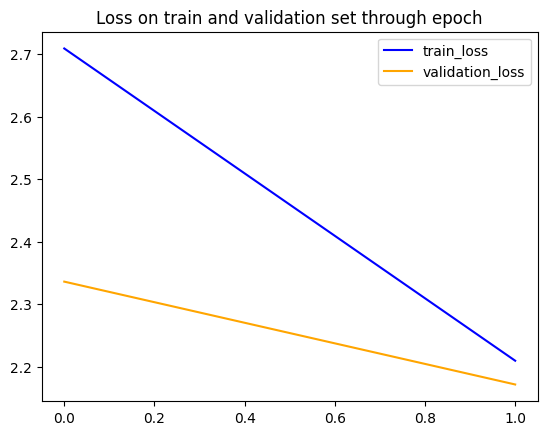

In [68]:
plot_train_and_val_loss(hist_2)

### c) Evaluation of the MCC model

In [ ]:
#model_1 = load_model('model/mcc_model_adam_ss=5000_epoch=4.keras')

In [69]:
df_one_test = pd.read_csv("dataframe/test_set_one_genre.csv")
df_one_test = df_one_test.sample(int(SAMPLE_SIZE_2*0.8), random_state=42)

In [70]:
ds_test_1 = get_dataset(poster_dir, df_one_test, BATCH_SIZE_2)

In [71]:
model_2.evaluate(ds_test_1)

62/62 [==============================] - 211s 3s/step - loss: 2.1398 - categorical_accuracy: 0.3065


[2.1397650241851807, 0.30645161867141724]

In [72]:
proba_2 = model_2.predict(ds_test_1)
y_hat_m2 = np.argmax(proba_2, axis=1)
print(proba_2[0])
print(y_hat_m2[0])

62/62 [==============================] - 180s 3s/step
[0.01212202 0.01107581 0.07979337 0.04637576 0.02199597 0.2811091
 0.19704397 0.01471501 0.03023682 0.02968092 0.068528   0.03739061
 0.02791929 0.02103791 0.01764894 0.03278366 0.02443658 0.03634749
 0.00975878]
5


In [73]:
y_true_one_hot = np.concatenate([y for x, y in ds_test_1], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)

In [74]:
with open('genre_to_index.json', 'r') as json_file:
            GTI = json.load(json_file)
index_to_genre = {v: k for k, v in GTI.items()}

In [75]:
y_pred_genres = [index_to_genre[idx] for idx in y_hat_m2]
y_true_genres = [index_to_genre[idx] for idx in y_true]

comparison_df_2 = pd.DataFrame({
    'true_genre': y_true_genres,
    'predict_genre': y_pred_genres
})

In [76]:
print(comparison_df_2.head(20))

     true_genre predict_genre
0        Comedy   Documentary
1   Documentary   Documentary
2   Documentary   Documentary
3   Documentary   Documentary
4        Horror   Documentary
5        Comedy         Drama
6         Music   Documentary
7     Adventure   Documentary
8       Western   Documentary
9         Drama   Documentary
10  Documentary   Documentary
11       Comedy   Documentary
12  Documentary   Documentary
13       Horror   Documentary
14  Documentary   Documentary
15      Romance   Documentary
16        Music   Documentary
17    Animation   Documentary
18        Drama   Documentary
19        Drama   Documentary


In view of these results, we can quickly deduce that our algorithm simply predicts the 2 most represented genres of our dataset. We therefore need to balance it.

# IV- Multi-class Classification (MCC) with reduced number of class

Finally, in this last section, we will further reduce the set of films considered in the hope of obtaining better results. More precisely, in addition of keeping only films associated to one genre, we also decide to reduce the number of genders from which our model must choose. So looking at the df_one_genre dataset, we have chosen to keep the 6 most represented genres in this dataset, namely : Documentary, Drama, Comedy, Animation, Music, and Horror.
Moreover, we will balanced the number of films associated to each genre by limiting the number of film associated to the most reprensented genre. Let's see some statistics about this dataset.

In [77]:
df_genre_select = pd.read_csv("dataframe/df_genres_selected.csv")
print("Numbers of film in df_genre_select :", df_genre_select.shape[0],'\n')
print("Occurences of each genre in df_genre_select : \n\n", df_genre_select['genre'].value_counts(), "\n")
print("How our dataset looks like : \n\n", df_genre_select.head(10), "\n")

Numbers of film in df_genre_select : 133207 

Occurences of each genre in df_genre_select : 

 genre
['Documentary']    25000
['Drama']          25000
['Comedy']         25000
['Animation']      22507
['Music']          18072
['Horror']         17628
Name: count, dtype: int64 

How our dataset looks like : 

       filename            genre
0  1201801.jpg  ['Documentary']
1  1729592.jpg  ['Documentary']
2  1582065.jpg        ['Drama']
3  1389338.jpg        ['Drama']
4  1385974.jpg        ['Music']
5  1515843.jpg  ['Documentary']
6  1384988.jpg  ['Documentary']
7  1046045.jpg        ['Drama']
8  1590690.jpg        ['Music']
9  1871854.jpg        ['Music'] 



### a) Loading and building training and validation dataset

In [78]:
SAMPLE_SIZE_3 = 5000
BATCH_SIZE_3 = 64
poster_dir = 'posters/'
AUTO = tf.data.experimental.AUTOTUNE

In [79]:
df_select_train = pd.read_csv("dataframe/training_set_genres_selected.csv")
df_select_train = df_select_train.sample(int(SAMPLE_SIZE_3*0.8), random_state=42)
df_select_val = pd.read_csv("dataframe/validation_set_genres_selected.csv")
df_select_val = df_select_val.sample(int(SAMPLE_SIZE_3*0.2), random_state=42)

In [80]:
print("Number of film in training set :", df_select_train.shape[0], "\n")
print("Number of film in validation set :", df_select_val.shape[0], "\n")
print("sum : ", df_select_train.shape[0]+df_select_val.shape[0], "\n")

Number of film in training set : 4000 

Number of film in validation set : 1000 

sum :  5000 



In [81]:
genre_Number = 6
global genre_Number
ds_train_select = get_dataset(poster_dir, df_select_train, BATCH_SIZE_3)
ds_val_select = get_dataset(poster_dir, df_select_val, BATCH_SIZE_3)

### b) Creating and training the MCC model

We create a new instance of the MCCModel class, this time specifying num_classes=6.

In [82]:
mcc_3 = MCCModel(num_classes=6)
model_3 = mcc_3.get_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model_3.summary()
hist_3 = model_3.fit(ds_train_select, epochs=2, validation_data=ds_val_select, callbacks = [early_stopping])
#model_3.save('model/mcc_model_balanced6_adam_ss=10000_epoch=6.keras')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_15 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_16 (Ba  (None, 125, 125, 32)     

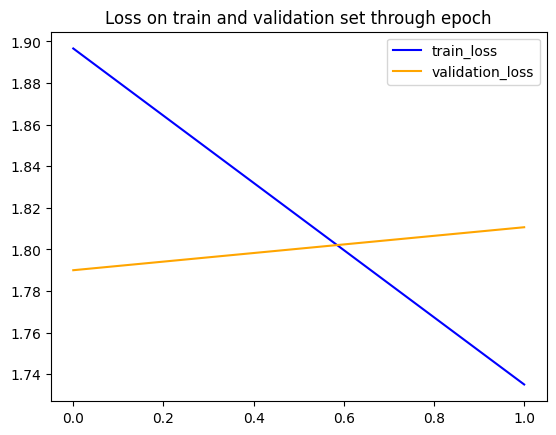

In [83]:
plot_train_and_val_loss(hist_3)

### c) Evaluation of the MCC model

In [84]:
#from tensorflow.keras.models import load_model
#model_3 = load_model('model/mcc_model_balanced6_adam_ss=10000_epoch=6.keras')

In [85]:
df_select_test = pd.read_csv("dataframe/test_set_genres_selected.csv")
df_select_test = df_select_test.sample(int(SAMPLE_SIZE_3*0.8), random_state=42)

In [86]:
print(df_select_test.head())

          filename          genre
9710   1585012.jpg     ['Comedy']
8121   1299904.jpg  ['Animation']
1610   1747920.jpg     ['Horror']
12326  1380546.jpg      ['Drama']
26012  1426129.jpg      ['Music']


In [87]:
ds_test_select = get_dataset(poster_dir, df_select_test, BATCH_SIZE_3)

In [88]:
model_3.evaluate(ds_test_select)

62/62 [==============================] - 204s 3s/step - loss: 1.8240 - categorical_accuracy: 0.1716


[1.8240469694137573, 0.17162297666072845]

In [89]:
proba_m3 = model_3.predict(ds_test_select)
y_hat_m3 = np.argmax(proba_m3, axis=1)
print(proba_m3[0])
print(y_hat_m3[0])

62/62 [==============================] - 182s 3s/step
[0.21837056 0.07206407 0.2112577  0.23152986 0.19031751 0.07646038]
3


In [90]:
y_true_one_hot_m3 = np.concatenate([y for x, y in ds_test_select], axis=0)
y_true_m3 = np.argmax(y_true_one_hot_m3, axis=1)

In [91]:
with open('genre_to_index_selected.json', 'r') as json_file:
            GTI = json.load(json_file)
index_to_genre_sel = {v: k for k, v in GTI.items()}

In [92]:
y_pred_genres_m3 = [index_to_genre_sel[idx] for idx in y_hat_m3]
y_true_genres_m3 = [index_to_genre_sel[idx] for idx in y_true_m3]

comparison_df_selected = pd.DataFrame({
    'true_genre': y_true_genres_m3,
    'predict_genre': y_pred_genres_m3
})